In [1]:
from urllib.request import urlopen
import bs4
import datetime as dt

def date_format(d):
    d = str(d).replace('-','.')
    yyyy = int(d.split('.')[0])
    mm = int(d.split('.')[1])
    dd = int(d.split('.')[2])
    this_date = dt.date(yyyy,mm,dd)
    return this_date

def historical_index_naver(index_cd, start_date='', end_date='', page_n=1, last_page=0):
    if start_date:
        start_date = date_format(start_date)
    else:
        start_date = dt.date.today()
    if end_date:
        end_date = date_format(end_date)
    else:
        end_date = dt.date.today()
        
    naver_index = "http://finance.naver.com/sise/sise_index_day.nhn?code=" + index_cd+ '&page='+ str(page_n)
    
    source = urlopen(naver_index).read()    #지정한 페이지에서 코드 읽기
    source = bs4.BeautifulSoup(source, 'lxml')    #뷰티풀 수프로 태그별로 코드 분류
    
    dates=source.find_all('td',class_='date')     #<td class="date">태그에서 날짜 수집
    prices=source.find_all('td',class_='number_1')     #<td class="number_1">태그에서 지수 수집
    
    for n in range(len(dates)):
        if dates[n].text.split('.')[0].isdigit():
            #날짜 처리
            this_date = dates[n].text
            this_date = date_format(this_date)
            
            if this_date <= end_date and this_date >= start_date:
                
                #종가 처리
                this_close = prices[n*4].text
                this_close = this_close.replace(',','')
                this_close = float(this_close)
            
                #딕셔너리에 저장
                historical_prices[this_date] = this_close
            elif this_date < start_date:
                return historical_prices
    
    #페이지네이션
        if last_page==0:
            last_page = source.find('td', class_='pgRR').find('a')['href']
            last_page = last_page.split('&')[1]
            last_page = last_page.split('=')[1]
            last_page = int(last_page)
        if page_n < last_page:
            page_n = page_n + 1
            historical_index_naver(index_cd, start_date, end_date, page_n, last_page)
    
        return historical_prices
    

In [2]:
import pandas as pd
from urllib.request import urlopen
import json

def date_format(d=''):    #날짜를 파이썬이 사용하는 실제 날짜 형식으로 변환
    if d!= '':
        this_date = pd.to_datetime(d).date()   
    else:
        this_date = pd.Timestamp.today().date()   #빈칸일 경우 오늘 날짜입력
    return (this_date)

def index_global(d, symbol,start_date='',end_date='',page=1):  #json 크롤링
    end_date = date_format(end_date)
    if start_date == '':
        start_date = end_date - pd.DateOffset(months=1)
    start_date = date_format(start_date)
    
    url='https://finance.naver.com/world/worldDayListJson.nhn?symbol='+symbol+'&fdtc=0&page=' +str(page)
    raw = urlopen(url)
    data = json.load(raw)
    
    if len(data)>0:        #페이지네이션
        for n in range(len(data)):
            date = pd.to_datetime(data[n]['xymd']).date()
            if date <= end_date and date >= start_date:
                price = float(data[n]['clos'])
                d[date]=price
            elif date <start_date:
                return(d)
        if len(data) == 10:
            page+=1
            index_global(d,symbol,start_date,end_date,page)
    
    return (d)

indices = {
    'SPI@SPX' : 'S&P 500',
    'NAS@NDX' : 'Nasdaq 100',
    'NII@NI225' : 'Nikkei 225'
}


historical_indices = dict()
start_date = '2020-07-01'
end_date = '2019-03-01'
for key, value in indices.items() :
    s = dict()
    s = index_global(s, key, start_date)
    historical_indices[value] = s
prices_df = pd.DataFrame(historical_indices)


In [5]:
index_cd = "KPI200"
historical_prices=dict()
kospi200 = historical_index_naver(index_cd, '2008-1-1', '2020-07-10')

In [6]:
index_cd = "SPI@SPX"
historical_prices=dict()
sp500 = index_global(historical_prices, index_cd, '2008-1-1', '2020-07-10')

In [111]:
tmp = {'S&P500' : sp500, 'KOSPI200' : kospi200}
df = pd.DataFrame(tmp)
df= df.fillna(method='ffill') #forward fill방법으로 NaN의 칸을 앞의 날짜의 수를 가져와서 보간함.
if df.isnull().values.any():
    df = df.fillna(method='bfill')
    
df


,S&P500,KOSPI200
2020-07-09,3152.05,283.86
2020-07-08,3169.94,283.86
2020-07-07,3145.32,283.86
2020-07-06,3179.72,283.86
2020-07-02,3130.01,283.86
...,...,...
2012-02-20,1447.16,265.95
2011-09-05,1447.16,228.89
2010-01-18,1447.16,224.38
2009-02-16,1447.16,152.66


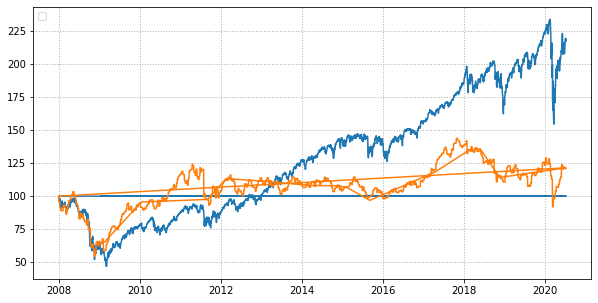

In [103]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10,5))  #크기조절
plt.plot(df['S&P500']/df['S&P500'].loc[dt.date(2008,1,2)]*100)    #S&P500과KOSPI200의 차이를 비율로 전환
plt.plot(df['KOSPI200']/df['KOSPI200'].loc[dt.date(2008,1,2)]*100)
plt.legend(loc='upper left',handles='')   #범례위치 지정
plt.grid(True, color='0.7',linestyle=':', linewidth=1)



In [95]:
df_ratio_2019_now = df.loc[:dt.date(2019,1,2)]/df.loc[dt.date(2019,1,2)]*100
df_ratio_2019_now

#df_ratio_2016_now = df.loc[dt.date(2008,1,1)]/df.loc[dt.date(2008,1,4)]*100

#df_ratio_2016_now.head(3)

,S&P500,KOSPI200
2020-07-09,125.578180,109.32409
2020-07-08,126.290921,109.32409
2020-07-07,125.310056,109.32409
2020-07-06,126.680558,109.32409
2020-07-02,124.700103,109.32409
...,...,...
2019-01-08,102.564910,100.00000
2019-01-07,101.580061,100.00000
2019-01-04,100.872898,100.00000
2019-01-03,97.524332,100.00000


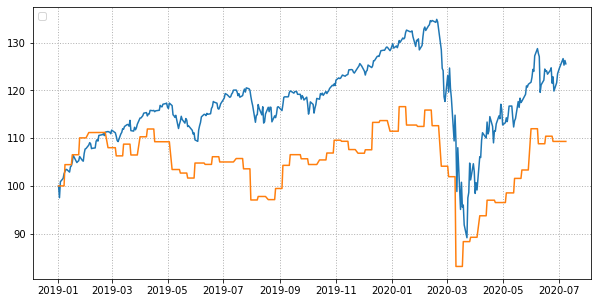

In [105]:
plt.figure(figsize=(10,5))
plt.plot(df_ratio_2019_now['S&P500'])
plt.plot(df_ratio_2019_now['KOSPI200'])
plt.legend(loc='upper left',handles='')
plt.grid(True, color='0.7', linestyle=':', linewidth=1)

Text(0, 0.5, 'KOSPI200')

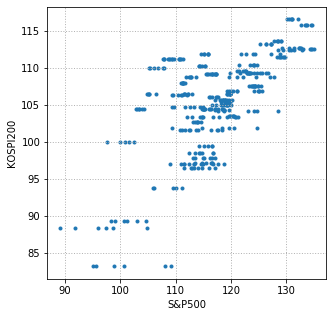

In [106]:
plt.figure(figsize=(5,5))
plt.scatter(df_ratio_2019_now['S&P500'], df_ratio_2019_now['KOSPI200'], marker='.')
plt.grid(True, color='0.7', linestyle=':', linewidth=1)
plt.xlabel('S&P500')
plt.ylabel('KOSPI200')

In [108]:
import numpy as np
from sklearn.linear_model import LinearRegression

x = df_ratio_2019_now['S&P500']
y = df_ratio_2019_now['KOSPI200']

#1개의 칼럼 np.array로 변환
independent_var = np.array(x).reshape(-1,1)
dependent_var = np.array(y).reshape(-1,1)

#linear regression
regr = LinearRegression()
regr.fit(independent_var, dependent_var)

result = {'Slope':regr.coef_[0,0], 'Intercept:':regr.intercept_[0], 'R^2':regr.score(independent_var,dependent_var)}
result

{'Slope': 0.5208254720225609,
 'Intercept:': 44.29013730189099,
 'R^2': 0.4343032345256882}

Text(0, 0.5, 'KOSPI200')

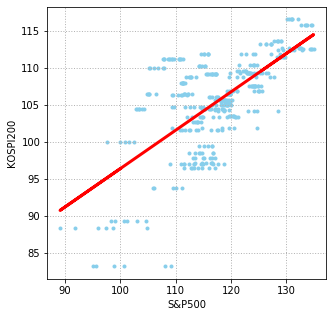

In [110]:
plt.figure(figsize=(5,5))
plt.scatter(independent_var, dependent_var, marker='.', color='skyblue')
plt.plot(independent_var, regr.predict(independent_var), color='r', linewidth=3)
plt.grid(True, color='0.7',linestyle=':', linewidth=1)
plt.xlabel('S&P500')
plt.ylabel('KOSPI200')